### Next character prediction using a multi layer perceptron

From https://www.youtube.com/watch?v=TCH_1BHY58I&t=1174s&ab_channel=AndrejKarpathy 

Inspired by the Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
### Next character prediction using a multi layer perceptron

From https://www.youtube.com/watch?v=TCH_1BHY58I&t=1174s&ab_channel=AndrejKarpathy 

Inspired by the Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

What's covered in this notebook:
- how to train the model using mini-batch training and backpropagation
- how to find the empirically find the optimal learning rate
- how to split the data into train/val/test sets
- the effect of a deeper hidden layer on the model
- the effect of a larger embedding space on the model
- how to visualize the embedding space
- how to sample from the model
- how to evaluate the model on unseen data


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
# Notes on sets
exSet = {23, 123, 23}
print(exSet, type(exSet), len(exSet)) 
# set in python are unnordered collection of unique elements that's why the len of exSet is 2
# as they are unnordered, they are not indexed 
# exSet[0] # doesn't work for that reason  
# we can update them 
exSet.add(1)
print(exSet)
exSet.remove(1)
print(exSet)
# we can verify the existence of an element in the set
print(123 in exSet)

{123, 23} <class 'set'> 2
{1, 123, 23}
{123, 23}
True


In [6]:
# Notes on enumerate
# it's used to add a counter on any subscriptable (such as a list) 
# and it returns this subscriptable as an enumerate object
# An enumerate object can then be used to obtain both the value and the index 

l =  ['a', 'b', 'c', 'd']
print(type(enumerate(l)))

for index, value in enumerate(l):
    print(index,value)

# this is the basic way to create the dict associated to this enumeration
dict = {}
print(enumerate(l))
for i,s in enumerate(l):
    print(i,s)
    dict[s] = i
print(dict)

# it's equivalent to this dict comprehension where the syntax a:b means the key a is assigned the value b
dict = {s:i for i,s in enumerate(l)}
print(dict)

<class 'enumerate'>
0 a
1 b
2 c
3 d
0 a
1 b
2 c
3 d
{'a': 0, 'b': 1, 'c': 2, 'd': 3}
{'a': 0, 'b': 1, 'c': 2, 'd': 3}


In [7]:
# build the vocabulary of characters and mappings to/from integers
charsSet = set(''.join(words)) # join concatenates all the words (chars actually) into a single string and set creates a set of unique elements from that str
# it's a quick way to get all the chars the file 

chars = sorted(list(charsSet)) # we convert the set to a list so that we can sort it 
print(chars[:5], len(chars)) # we now have the sorted list of the 26 chars of the alphabet

# we create the mappings
stoi = {s:i+1 for i,s in enumerate(chars)} # str to int dict
stoi['.'] = 0 # used to mark the end of a word
itos = {i+1:s for i,s in enumerate(chars)} # int to str dict
itos[0] = '.' 
print(stoi)
print(itos)


['a', 'b', 'c', 'd', 'e'] 26
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
# build the dataset

block_size = 3 # context length : how many chars do we take to predict the next one
X, Y = [], []
for w in words[:3]:
    print('\n', w)
    context = [0] * block_size # create the empty list of appropriate size 0's are "."
    for ch in w + '.': # add a dot at the end of the word 
        ix = stoi[ch] # retrieve the index of the ch
        X.append(context) 
        Y.append(ix) # target is the index of the ch

        print(''.join(itos[i] for i in context), '--->', itos[ix]) # visually understand the X's and Y's
        context = context[1:] + [ix] # crop to the left and add the next index to the right 
    
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X, X.shape) # each line is a context window 
print(Y, Y.shape) # list of all the expected following char for each context window


 emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

 olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

 ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]]) torch.Size([16, 3])
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0]) torch.Size([16])


In [9]:
# some examples

print("for the word :", words[0])
for i in range(len(words[0])):
    print("\nfor the context : ", X[i])
    print("which is : ", [itos[i.item()] for i in X[i]])
    print("we have the excpected index", Y[i])
    print("which is : ", itos[Y[i].item()])


for the word : emma

for the context :  tensor([0, 0, 0])
which is :  ['.', '.', '.']
we have the excpected index tensor(5)
which is :  e

for the context :  tensor([0, 0, 5])
which is :  ['.', '.', 'e']
we have the excpected index tensor(13)
which is :  m

for the context :  tensor([ 0,  5, 13])
which is :  ['.', 'e', 'm']
we have the excpected index tensor(13)
which is :  m

for the context :  tensor([ 5, 13, 13])
which is :  ['e', 'm', 'm']
we have the excpected index tensor(1)
which is :  a


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

### Embedding space

The idea is to embed the characters in a smaller dimensional space 

In the paper, they predicts words in a sentence, so they have 17000 words embedded in a 30 dimensional space. Here we predict the next character in a sequence of characters, so we will embed 27 characters in a 2 dimensional space to start with.

The intuition behind this embedding space is that similar characters will be close to each other in the 2D space, and the MLP will learn to predict the next character based on the previous characters and the position of the characters in the embedding space.


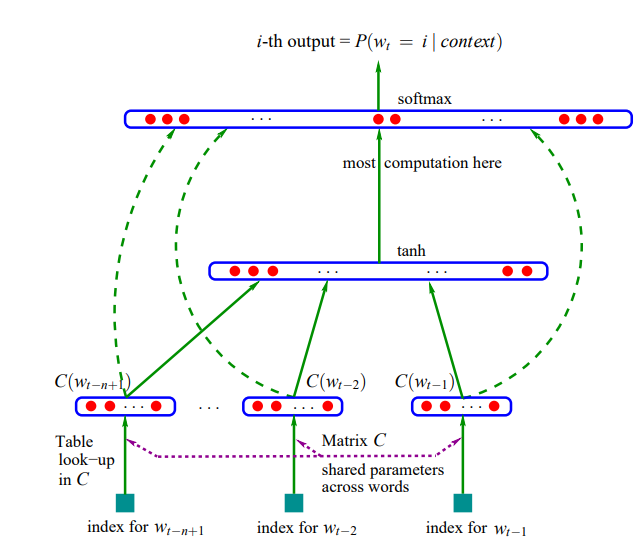

In [11]:
# We start with a random embedding 
# For each index, we have a point in R^2
emb_dim = 2
C = torch.randn((27,emb_dim))
print(C[:6])
C[5], itos[5] # coordinates of 5 which is 'e'

tensor([[ 0.3885,  1.7045],
        [-0.6237,  0.0622],
        [-0.8705,  0.3940],
        [ 0.5872,  1.2390],
        [ 0.3197,  0.4360],
        [-2.0289, -0.7413]])


(tensor([-2.0289, -0.7413]), 'e')

In [12]:
# The lookup table to the embedding space C[i] can be thought of as the first linear layer in the bigger nn showed above
# Indeed, if we encode the indexes using one_hot_encoding, then C[i] = encoded_i dot C (easily verifiable by hand)
# So we input the encoded indexes and we treat C as weights  
# It's faster to just use C[i] so we will use that but it's a fun fact

print(C[5])
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # we convert to float bc by default it's a long float and C is just a float

tensor([-2.0289, -0.7413])


tensor([-2.0289, -0.7413])

In [13]:
# How to embed X in one shot ? 

print(C[5]) # embeds 5
print(C[[1,2,3]]) # embeds 1,2,3
print(C[torch.tensor([1,2,3,3])]) # works with tensors and the same element multiple times (not only with tensors)

print(C[X][0]) # embeding of the first context (['.','.','.'])
print(C[X].shape)

# it's an array of all matrices of embeded contexts
# a matrice of embeded context is created from a context list that is embeded just as in the example with C[[1,2,3]]
# So C[X][i] gives the embedding of the ith context
# C[X][i][j] gives the embedding of the jth int in the ith context

# To "give the embedding" of the jth int is to give its coordonates in the 2D space C

tensor([-2.0289, -0.7413])
tensor([[-0.6237,  0.0622],
        [-0.8705,  0.3940],
        [ 0.5872,  1.2390]])
tensor([[-0.6237,  0.0622],
        [-0.8705,  0.3940],
        [ 0.5872,  1.2390],
        [ 0.5872,  1.2390]])
tensor([[0.3885, 1.7045],
        [0.3885, 1.7045],
        [0.3885, 1.7045]])
torch.Size([16, 3, 2])


In [14]:
print(X[3,2]) #the 2nd int of the 3rd context is 13 here
print(C[X][3,2]) 
print(C[13]) 
# we see that to retrieve the embeding of a certain number in X,
# we can do that by looking up it's value in C[X] at the exact location we found it in X

print()
print(X[3])
print(C[X][3])
print(C[[ 5, 13, 13]])
# works for entiere contexts as well 

tensor(13)
tensor([-0.6957,  0.8036])
tensor([-0.6957,  0.8036])

tensor([ 5, 13, 13])
tensor([[-2.0289, -0.7413],
        [-0.6957,  0.8036],
        [-0.6957,  0.8036]])
tensor([[-2.0289, -0.7413],
        [-0.6957,  0.8036],
        [-0.6957,  0.8036]])


In [15]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

### Model 

Now that we have the embedding space, we create the model displayed in the image above.

In [16]:
# let's build the first hidden layer of the image 
input_size = block_size*emb_dim
nbr_neurons_1 = 100
W1 = torch.randn((input_size, nbr_neurons_1)) # wheights matrix of the first hidden layer
b1 = torch.randn(nbr_neurons_1) # for each neuron we have a random bias 
W1.shape, b1.shape

# The input size in not only block_size (nbr of chars in context) because each neuron is a coordinate of a char in the embedding space
# Each row of W1 corresponds to the weights connecting one input neuron to all neurons in the hidden layer
# Each column of W1 corresponds to the weights connecting all input neurons to one neuron in the hidden layer


(torch.Size([6, 100]), torch.Size([100]))

In [17]:
# We cannot simply perform emb @ W1 + b1 because as we said, emb is a list of embeded contexts (matrices)
print(emb.shape, W1.shape)

# we must concatenate the embeddings for each input layer 
print(emb[:,0,:]) # gives for each context, the embeding of the first char 
print(emb[:,0,:].shape)
conc_emb = torch.cat([emb[:,i,:] for i in range(block_size)], axis=1) # we concatenate the list of all the embedings of the chars in a context window
# we are doing the concatenation on the columns 
# So for each line, we have 6 numbers coresponding to 3 embedings in C
print(conc_emb, conc_emb.shape)

torch.Size([16, 3, 2]) torch.Size([6, 100])
tensor([[ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [-2.0289, -0.7413],
        [-0.6957,  0.8036],
        [ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [-0.5697, -0.0088],
        [ 2.1364,  0.0556],
        [-0.2737,  0.0165],
        [-0.3856,  0.8525],
        [ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [ 0.3885,  1.7045],
        [-0.6237,  0.0622]])
torch.Size([16, 2])
tensor([[ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
        [ 0.3885,  1.7045,  0.3885,  1.7045, -2.0289, -0.7413],
        [ 0.3885,  1.7045, -2.0289, -0.7413, -0.6957,  0.8036],
        [-2.0289, -0.7413, -0.6957,  0.8036, -0.6957,  0.8036],
        [-0.6957,  0.8036, -0.6957,  0.8036, -0.6237,  0.0622],
        [ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
        [ 0.3885,  1.7045,  0.3885,  1.7045, -0.5697, -0.0088],
        [ 0.3885,  1.7045, -0.5697, -0.

In [18]:
# a better way to create conc_emb is to use the unbind method
# it removes a dimension exactly like [emb[:,i,:] for i in range(block_size)]

#Ex : 
M = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

test_rows = torch.unbind(torch.tensor(M), 0) 
test_col = torch.unbind(torch.tensor(M), 1)

print(test_rows)
print(test_col)

conc_emb = torch.cat(torch.unbind(emb, 1), 1)
conc_emb, conc_emb.shape
 

(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
(tensor([1, 4, 7]), tensor([2, 5, 8]), tensor([3, 6, 9]))


(tensor([[ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
         [ 0.3885,  1.7045,  0.3885,  1.7045, -2.0289, -0.7413],
         [ 0.3885,  1.7045, -2.0289, -0.7413, -0.6957,  0.8036],
         [-2.0289, -0.7413, -0.6957,  0.8036, -0.6957,  0.8036],
         [-0.6957,  0.8036, -0.6957,  0.8036, -0.6237,  0.0622],
         [ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
         [ 0.3885,  1.7045,  0.3885,  1.7045, -0.5697, -0.0088],
         [ 0.3885,  1.7045, -0.5697, -0.0088,  2.1364,  0.0556],
         [-0.5697, -0.0088,  2.1364,  0.0556, -0.2737,  0.0165],
         [ 2.1364,  0.0556, -0.2737,  0.0165, -0.3856,  0.8525],
         [-0.2737,  0.0165, -0.3856,  0.8525, -0.2737,  0.0165],
         [-0.3856,  0.8525, -0.2737,  0.0165, -0.6237,  0.0622],
         [ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
         [ 0.3885,  1.7045,  0.3885,  1.7045, -0.6237,  0.0622],
         [ 0.3885,  1.7045, -0.6237,  0.0622, -0.3856,  0.8525],
         [-0.6237,  0.062

In [37]:
# 3rd method : view method (like reshape in numpy)

a = torch.arange(18)
print(a, a.shape)

print(a.view(2,9))
print(a.view(3,3,2))

# we can reshape the tensor the way we wan't as long as the size is conserved
# It's extremely efficient thanks to the inner workings of torch
# Because each vector has a storage, which is the list of all its elements
# This is fixed and only its representation changes
# So we don't change/create/delete memory when using .view()
a.storage()

# whereas when we concatenate using bind, we create a whole new tensor with new storage --> inneficient

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]) torch.Size([18])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [20]:
# let's use that to solve our original pb i.e multiply emb and W1
conc_emb = emb.view(emb.shape[0], input_size)
print(conc_emb, conc_emb.shape) # once again the same matrix 

h = conc_emb @ W1 + b1 # 16x6 @ (3*2)x100 + 100 = len(X)x(block_size*emb_dim) @ (block_size*emb_dim)x(nbr_neurons_1) + nbr_neurons_1
h, h.shape
# i.e., this is the list of outputs from the linear transformation for each example in X for each of our 100 neurons in the hidden layer

tensor([[ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
        [ 0.3885,  1.7045,  0.3885,  1.7045, -2.0289, -0.7413],
        [ 0.3885,  1.7045, -2.0289, -0.7413, -0.6957,  0.8036],
        [-2.0289, -0.7413, -0.6957,  0.8036, -0.6957,  0.8036],
        [-0.6957,  0.8036, -0.6957,  0.8036, -0.6237,  0.0622],
        [ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
        [ 0.3885,  1.7045,  0.3885,  1.7045, -0.5697, -0.0088],
        [ 0.3885,  1.7045, -0.5697, -0.0088,  2.1364,  0.0556],
        [-0.5697, -0.0088,  2.1364,  0.0556, -0.2737,  0.0165],
        [ 2.1364,  0.0556, -0.2737,  0.0165, -0.3856,  0.8525],
        [-0.2737,  0.0165, -0.3856,  0.8525, -0.2737,  0.0165],
        [-0.3856,  0.8525, -0.2737,  0.0165, -0.6237,  0.0622],
        [ 0.3885,  1.7045,  0.3885,  1.7045,  0.3885,  1.7045],
        [ 0.3885,  1.7045,  0.3885,  1.7045, -0.6237,  0.0622],
        [ 0.3885,  1.7045, -0.6237,  0.0622, -0.3856,  0.8525],
        [-0.6237,  0.0622, -0.3856,  0.8

(tensor([[-4.5415,  2.7443,  0.4297,  ...,  2.9786,  3.1267, -5.6671],
         [-3.0631, -1.1155,  3.5606,  ...,  1.1780, -0.1174, -2.8025],
         [-4.7380,  3.1788, -2.3947,  ...,  2.3151, -1.2038,  1.7295],
         ...,
         [-2.6529,  0.1989,  2.6284,  ...,  1.7835,  2.0415, -3.3106],
         [-4.5924,  2.7116, -0.7107,  ...,  2.1276,  0.5616, -1.9809],
         [-1.3663, -0.9755,  2.1502,  ..., -0.8452, -2.1637,  0.9517]]),
 torch.Size([16, 100]))

In [21]:
h = torch.tanh(h) # non linear transformation 
h

tensor([[-0.9998,  0.9918,  0.4051,  ...,  0.9948,  0.9962, -1.0000],
        [-0.9956, -0.8060,  0.9984,  ...,  0.8268, -0.1169, -0.9927],
        [-0.9998,  0.9965, -0.9835,  ...,  0.9807, -0.8348,  0.9390],
        ...,
        [-0.9901,  0.1963,  0.9896,  ...,  0.9451,  0.9668, -0.9973],
        [-0.9998,  0.9912, -0.6111,  ...,  0.9720,  0.5092, -0.9627],
        [-0.8778, -0.7511,  0.9732,  ..., -0.6885, -0.9739,  0.7405]])

In [22]:
# Let's build the second hidden layer
nbr_neurons_2 = 27 # because we have 27 chars
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2 
logits, logits.shape

# for each example, we have 27 outputs. But we wan't probabilities 

(tensor([[-1.6858e+01, -6.5172e+00,  9.5111e-01, -7.6087e+00, -2.1549e+00,
          -6.7437e+00, -1.1500e+01,  1.2910e+01, -1.1647e+01,  7.7229e+00,
          -7.9901e-01,  1.9915e+01, -6.0753e+00,  1.0883e+01, -7.2227e+00,
           1.0994e+01, -9.4991e+00, -8.6996e-01,  7.9288e+00,  7.7902e-02,
           1.1564e+01,  2.8135e+01,  1.0429e+01,  9.2909e+00,  9.2846e+00,
           4.9469e+00,  4.6959e+00],
         [-1.2192e+01, -3.0976e+00,  1.6924e+01, -3.3419e+00, -1.1957e+01,
          -5.9802e+00, -8.7903e+00,  1.1120e+01, -1.0348e+01, -7.2343e+00,
           1.0367e+01,  1.2567e+01, -7.0397e+00, -1.8258e+00, -8.3189e+00,
           5.8200e+00, -1.5224e+01,  2.0182e+00,  1.8865e+00,  7.3644e+00,
           1.6769e+01,  1.9466e+01,  1.5261e+00,  1.0008e+00,  4.3461e-01,
          -1.2558e+01, -1.3455e+00],
         [-1.5265e+01,  4.0488e+00,  8.6846e-01,  1.8613e+00,  1.1712e+01,
          -8.9255e+00,  2.0011e+01,  6.8001e+00, -7.3975e+00, -8.5397e+00,
           7.8744e+00,  8.

In [23]:
# Thus, we (manually) create the softmax

counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
print(prob.shape)
print(prob)
prob.sum(1, keepdim=True) # we see that each row sums to 1 (these are probability distributions as we wanted)

torch.Size([16, 27])
tensor([[2.8828e-20, 8.9243e-16, 1.5632e-12, 2.9960e-16, 6.9996e-14, 7.1155e-16,
         6.1195e-18, 2.4407e-07, 5.2789e-18, 1.3644e-09, 2.7161e-13, 2.6914e-04,
         1.3882e-15, 3.2174e-08, 4.4072e-16, 3.5940e-08, 4.5243e-17, 2.5300e-13,
         1.6764e-09, 6.5280e-13, 6.3557e-08, 9.9973e-01, 2.0427e-08, 6.5454e-09,
         6.5042e-09, 8.4986e-11, 6.6121e-11],
        [1.5530e-14, 1.3835e-10, 6.8586e-02, 1.0836e-10, 1.9642e-14, 7.7457e-12,
         4.6628e-13, 2.0691e-04, 9.8197e-14, 2.2102e-12, 9.7437e-05, 8.7914e-04,
         2.6848e-12, 4.9351e-10, 7.4711e-13, 1.0324e-06, 7.4945e-16, 2.3052e-08,
         2.0209e-08, 4.8368e-06, 5.8758e-02, 8.7147e-01, 1.4093e-08, 8.3349e-09,
         4.7314e-09, 1.0777e-14, 7.9783e-10],
        [4.3340e-16, 1.0582e-07, 4.3990e-09, 1.1872e-08, 2.2524e-04, 2.4540e-13,
         9.0554e-01, 1.6574e-06, 1.1311e-12, 3.6096e-13, 4.8527e-06, 5.9547e-06,
         2.4700e-15, 4.1251e-03, 1.2378e-11, 8.5944e-10, 1.3671e-13, 3.9327e-

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [24]:
print(prob[torch.arange(X.shape[0]), Y]) # tensor of the probabilities of the correct following chars 

loss = -prob[torch.arange(X.shape[0]), Y].log().mean() # negative log likelihood ~ cross_entropy
loss

# It's less efficient to implement ourselves the cross entropy loss (no memory re allocation, explicit gradient form = better backward pass, NaN handling...)

tensor([7.1155e-16, 4.9351e-10, 4.1251e-03, 4.9468e-11, 1.0045e-12, 3.5940e-08,
        3.1042e-15, 1.5016e-08, 5.1490e-01, 2.6264e-12, 1.2622e-05, 1.4647e-11,
        8.9243e-16, 1.7486e-08, 1.5492e-09, 2.8472e-07])


tensor(20.8216)

### Recap up to this point and training

We re implement the model in a condensed way and train it using backpropagation.

In [25]:
X.shape, Y.shape # dataset

(torch.Size([16, 3]), torch.Size([16]))

In [26]:
# hyper parameters
emb_dim = 2
block_size = 3
nbr_neurons = 100
step = 0.1

# constants
nbr_chars = 27

In [49]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nbr_chars, 2), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, nbr_chars), generator=g)
b2 = torch.randn(nbr_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

In [28]:
sum([p.nelement() for p in parameters])

3481

In [29]:
# The training / optimization 
for p in parameters:
    p.requires_grad = True # so that the gradient descent concerns all the params 

for _ in range(10):
    # Forward pass 
    emb = C[X] #(16, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -step * p.grad 
    
# It's that good because we are overfitting 16 examples 

20.24171257019043
14.233868598937988
10.578412055969238
7.819599628448486
6.053428649902344
4.864985466003418
3.8876328468322754
3.076685667037964
2.4039056301116943
1.8741708993911743


In [30]:
# Let's now create X and Y with all the words 

X,Y = [], []
for w in words:
    context = [0] * block_size # create the empty list of appropriate size 0's are "."
    for ch in w + '.': # add a dot at the end of the word 
        ix = stoi[ch] # retrieve the index of the ch
        X.append(context) 
        Y.append(ix) # target is the index of the ch
        context = context[1:] + [ix] # crop to the left and add the next index to the right 

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

torch.Size([228146, 3])
torch.Size([228146])


In [31]:
# We now train on the whole dataset 
for p in parameters:
    p.requires_grad = True # so that the gradient descent concerns all the params 

for _ in range(10):
    # Forward pass 
    emb = C[X] #(16, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -step * p.grad 

# We notice that the loss decreases much more slowly
# Also, each iteration takes time, we will use minibatching to adress that

13.740729331970215
13.09607219696045
12.531704902648926
12.029227256774902
11.577725410461426
11.171456336975098
10.805702209472656
10.47529411315918
10.174715042114258
9.89874267578125


### Mini batch training

The idea of mini batch training is to train the model on a small random subset of the data at a time.

The model is trained on the subset, and the weights are updated.

It is used because it balances the trade-off between the efficiency of stochastic gradient descent (SGD) and the stability of full-batch gradient descent.

It works because the mini-batch gradient is a good approximation of the full-batch gradient, and it is more computationally efficient than full-batch training.

The randomness is responsible for the up and downs in the loss curve.

Pros:

- Faster convergence compared to full-batch training.
- More stable updates compared to SGD.
- Better utilization of hardware resources.

Cons:

- Requires tuning of the batch size.
- May still be computationally expensive for very large datasets.
- Can introduce noise in the gradient updates.

#### Note : It's better to have an approximate of the gradient and make much more step than having the exact gradient and make less step.

In [32]:
ixs = torch.randint(0, X.shape[0], (32,)) # tensor of batch_size integers 
print(X[ixs][:5], X[ixs].shape) # X[ixs] --> tensor of batch_size rows of X located by the random ixs
Y[ixs][:5], Y[ix].shape # Corresponding ground thruths 

tensor([[ 0,  0,  0],
        [ 0,  0,  0],
        [14,  9, 12],
        [22, 15, 14],
        [ 0,  0,  4]]) torch.Size([32, 3])


(tensor([ 5, 12,  9,  0,  8]), torch.Size([]))

In [33]:
batch_size = 32

def minibatch_training(n):
    for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

    for _ in range(n):
        # minibatch construct 
        ixs = torch.randint(0, X.shape[0], (batch_size,)) 

        # Forward pass 
        emb = C[X[ixs]] 
        h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits,Y[ixs]) 
        print(loss.item())

        # Backward pass
        for p in parameters:
            p.grad = None # reset the gradients more efficiently than setting them to 0

        loss.backward()

        # update
        for p in parameters:
            p.data += -step * p.grad 
    
    return loss 
minibatch_training(100)
# Almost instantanous results with more iterations --> loss decreases faster 

10.317536354064941
8.764633178710938
10.907901763916016
10.634355545043945
9.704976081848145
8.30193042755127
6.805624485015869
9.069713592529297
8.17194938659668
6.629061698913574
8.072404861450195
8.038716316223145
7.939483165740967
6.9309306144714355
9.076131820678711
8.108695983886719
6.982093334197998
6.763941764831543
7.683953762054443
6.709555149078369
5.07699728012085
6.053630828857422
6.8117451667785645
5.354752063751221
6.667349815368652
5.690914154052734
7.7276740074157715
5.40645694732666
6.53068733215332
6.058970928192139
5.97503662109375
5.6116042137146
5.794808864593506
6.073169708251953
5.159719467163086
6.816597938537598
4.594086647033691
5.2468581199646
5.194203853607178
5.082757472991943
4.652572154998779
4.884854316711426
5.193840980529785
5.875397682189941
4.4736199378967285
5.922550201416016
4.27190637588501
5.477975845336914
7.323955535888672
3.912048816680908
4.803825855255127
4.354580879211426
5.409005165100098
4.946399688720703
4.167651176452637
4.186528205871

tensor(4.1807, grad_fn=<NllLossBackward0>)

In [47]:
minibatch_training(100)
# converges to ~2.5 on mini batches 

2.6355528831481934
2.7661399841308594
2.721900463104248
2.5069968700408936
3.048855781555176
2.8844552040100098
2.6070170402526855
2.13108229637146
2.64514422416687
2.840970039367676
2.683633804321289
2.468022346496582
2.406010150909424
2.622878074645996
2.7390542030334473
2.4803192615509033
2.9516756534576416
2.2709503173828125
2.4673593044281006
2.5825133323669434
2.1916821002960205
2.216161012649536
2.914738178253174
2.663822650909424
2.3957715034484863
2.5684139728546143
2.6807563304901123
2.318681001663208
2.799699544906616
2.2864036560058594
2.6074163913726807
2.9546566009521484
2.768932580947876
2.4840822219848633
2.845425605773926
2.828756093978882
2.3915178775787354
2.5202693939208984
2.4593799114227295
2.602020025253296
2.2034850120544434
2.325793743133545
2.520404100418091
2.6810710430145264
2.8736939430236816
2.5024819374084473
2.1797525882720947
2.3214828968048096
2.478311777114868
2.7950475215911865
2.6663005352020264
2.6087594032287598
2.5553336143493652
2.51867461204528

tensor(2.5579, grad_fn=<NllLossBackward0>)

In [48]:
# The loss on the whole data is : 
emb = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y) 
print(loss.item())

2.588754892349243


### Finding the optimal learning rate

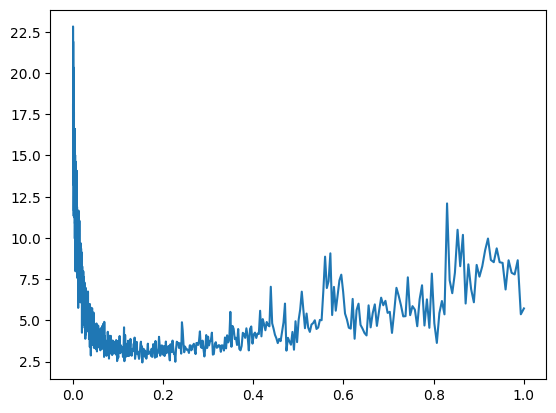

In [50]:

# empirically, we see that above 1, it's not optimizing/unstable and below 0.001 it's too slow 
# So now, we will search over possible candidates 
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 

lri = [] 
lossi = []
for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

for i in range(1000):
    # minibatch construct 
    ixs = torch.randint(0, X.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[X[ixs]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats on lrs
    lri.append(lr.item())
    lossi.append(loss.item())


plt.plot(lri, lossi)
# we see that the optimal rate can be approximated 
# Here it's around 0.1
# So we should set it at 0.1
# Then, we can lower it as the nbr of iterations increases (learning rate decay)

### Splitting the data into train/val/test

Prevents overfitting and helps to evaluate the model on unseen data.

The val split is used to tune the hyperparameters of the model, while the test split is used to evaluate the final performance of the model.

In [ ]:

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # create the empty list of appropriate size 0's are "."
        for ch in w + '.': # add a dot at the end of the word 
            ix = stoi[ch] # retrieve the index of the ch
            X.append(context) 
            Y.append(ix) # target is the index of the ch

            #print(''.join(itos[i] for i in context), '--->', itos[ix]) # visually understand the X's and Y's
            context = context[1:] + [ix] # crop to the left and add the next index to the right 

    return torch.tensor(X), torch.tensor(Y)

import random 
random.seed(42)
random.shuffle(words) 

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(n1, n2)
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

# The shapes are random because the sizes of the words contained in each sub set vary
 

25626 28829
torch.Size([182702, 3]) torch.Size([182702])
torch.Size([22670, 3]) torch.Size([22670])
torch.Size([22774, 3]) torch.Size([22774])


In [ ]:
# I put this code here to manually re set the model easily
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nbr_chars, 2), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, nbr_chars), generator=g)
b2 = torch.randn(nbr_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# We train the model using only Xtrain 
for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

for i in range(10000):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.01 * p.grad 

   
print(loss.item())
# 50k iterations with 0.1, 10k iterations with 0.01 --> 2.160

2.1604180335998535


In [ ]:
# loss on the whole training dataset : 
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr) 
print(loss) # 2.2877

tensor(2.2877, grad_fn=<NllLossBackward0>)


In [ ]:
# Now we evaluate on dev 
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev) 
print(loss) # 2.3019

# The losses are quite close so there is no overfitting 

tensor(2.3019, grad_fn=<NllLossBackward0>)


### Larger Hidden Layer

We've seen that the current model is underfitting, so we will increase the size of the hidden layer to see the effect on the loss curve.

In [ ]:
nbr_neurons = 300

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nbr_chars, 2), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, nbr_chars), generator=g)
b2 = torch.randn(nbr_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # 10281 parameters with 300 neurons

10281

tensor(2.3890, grad_fn=<NllLossBackward0>)


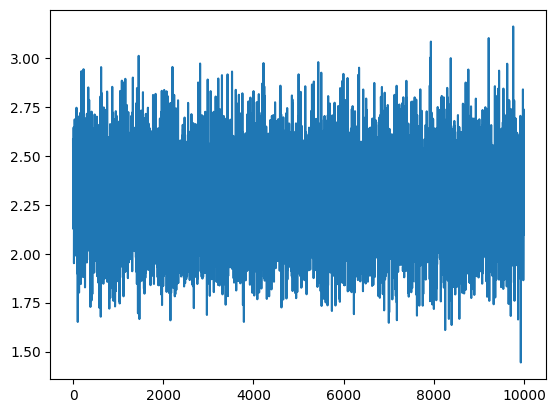

In [94]:
for p in parameters:
        p.requires_grad = True # so that the gradient descent concerns all the params 

stepi = [] # Warning : step refers to an iteration not a learning rate
lossi = []
for i in range(10000):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None # reset the gradients more efficiently than setting them to 0

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.01 * p.grad 

    stepi.append(i)
    lossi.append(loss.item())

print(loss) # 2.5253 after 30k steps at 0.1 to 2.2054 after 10k more steps at 0.01 
plt.plot(stepi, lossi)
# Mini batchs introduice a lot of noise as we can see 

In [ ]:
# on train 
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr) 
print(loss) 

# on dev 
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev) 
print(loss) 

# 2.6066, 2.6151 with 30k at 0.1 + 10k at 0.01
# So we didn't upgrade the performances 
# One of the reasons may be that the batch size is so low (32) that there is too much noise and we are not optimizing properly
# Also, the embedding space is propably too restrictive (2D)
# 
# Actually, playing with the learning rates and training the model longer give better results (as excpected bc of the bigger size) 
# I've reached 2.2684 on training and 2.2886 on dev 

tensor(2.2684, grad_fn=<NllLossBackward0>)
tensor(2.2886, grad_fn=<NllLossBackward0>)


### Embedding Visualization and scaling

torch.Size([27, 2])


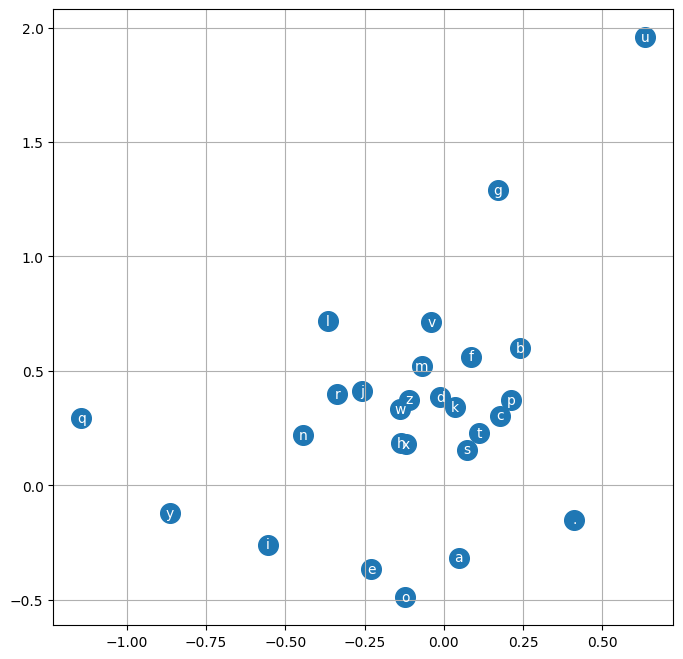

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# We see that the vowels are separated from the rest on the top of the image, except for "u" which has a very special embedding (alone in the top right).
# The dot and some other characters ('q', 'g') are also isolated.
# I don't really know what the interpretation is.
# The remaining letters are clustered together.

In [106]:
# Now let's scale this embedding space

nbr_neurons = 200 # we down scale the nbr neurons to keep a reasonnable amount of total params 
emb_dim = 10

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nbr_chars, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, nbr_chars), generator=g)
b2 = torch.randn(nbr_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # from 10281 to 11681

11897

In [107]:
for p in parameters:
        p.requires_grad = True 

stepi = [] 
lossi = []

tensor(2.3038, grad_fn=<NllLossBackward0>)


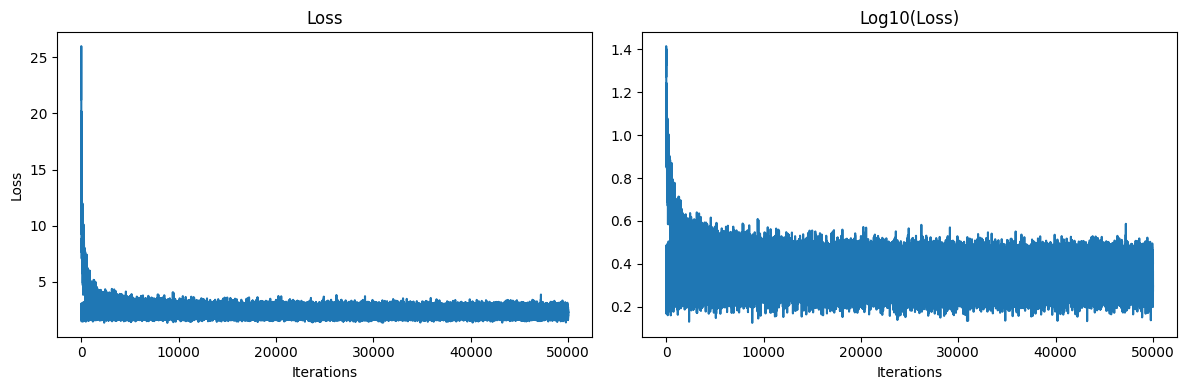

In [114]:

for i in range(50000):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None 

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.001 * p.grad 

    stepi.append(i)
    lossi.append(loss.item())

import numpy as np

print(loss)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(stepi, lossi)
axes[0].set_title("Loss")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Loss")

axes[1].plot(stepi, np.log10(np.array(lossi))) # taking the log makes it clearer as it squashes the values vertically
axes[1].set_title("Log10(Loss)")
axes[1].set_xlabel("Iterations")

plt.tight_layout()
plt.show()

In [ ]:
# on train 
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,emb_dim*block_size) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr) 
print(loss) 

# on dev 
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,emb_dim*block_size) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev) 
print(loss) 

# After some training, I'm reaching 2.1190 on test and 2.1686 which are the best losses

tensor(2.1190, grad_fn=<NllLossBackward0>)
tensor(2.1686, grad_fn=<NllLossBackward0>)


### Sampling from the model

In [117]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))



junide.
jakarie.
presay.
adin.
kaileitolett.
juham.
dameia.
yanilenias.
dedainrorett.
seby.
evy.
arten.
avaunestion.
maj.
ponis.
jah.
jaylinora.
yae.
anna.
jaabi.


## Conclusion

We have seen how to train a multi-layer perceptron to predict the next character in a sequence of characters using an embedding space.

We have seen how to train the model using mini-batch training, how to find the optimal learning rate, how to split the data into train/val/test, how to increase the size of the hidden layer to reduce underfitting, how to visualize the embedding space, how to sample from the model, and how to evaluate the model on unseen data.

The results are not insane but the names sampled from the model are looking like real names. (pretty much haha)

#### Explorations to beat the current loss : 
- Try different embedding sizes
- Try different hidden layer sizes
- Try different learning rates
- Try different sequence lengths
- Try different activation functions

#### Explorations to mimic a production ready notebook :
- Optimize  batch sizes (training time optimization)
- Make sure to have no hard coded values
- Try to implement a systematic way to find the optimal hyperparameters
- Find the optimal learning rates and decay rates
- Try to implement a systematic way to evaluate the model (k-fold cross validation)
- Try a way to save the model and load it to make predictions

#### Other exercises : 
- Use this to implement a model trained on words to generate text as in the paper
- Make it deeper and create your own MLP architecture




